In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime
from time import time
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Fil

In [3]:
parcels_taxvals_merged_url = 'https://media.githubusercontent.com/media/rohanskalyani/sfpermittimes/main/Data/parcels_taxvals_merged.csv?raw=true'
SFDBIData_url = 'https://media.githubusercontent.com/media/rohanskalyani/sfpermittimes/main/Data/SFDBI_Permits.csv?raw=true'
sf_census_data = gpd.read_file('https://raw.githubusercontent.com/rohanskalyani/sfpermittimes/main/Data/Block%20Group%20Median%20Household%20Income.geojson'); sf_census_data.head()
parcels_taxvals_merged = pd.read_csv(parcels_taxvals_merged_url, index_col = 0)
SFDBIPermit = pd.read_csv(SFDBIData_url)

In [378]:
#(parcels_taxvals_merged.isna()).sum()/len(parcels_taxvals_merged)
parcels_taxvals_merged.shape

(191703, 27)

In [17]:
Master_merge = parcels_taxvals_merged.merge(SFDBIPermit, how='inner', left_on='mapblklot', right_on='Parcel Number')
Master_merge.shape

(691, 59)

In [18]:
Master_merge['geometry_y'] = gpd.GeoSeries.from_wkt(Master_merge['geometry_y'])
Master_merge_geo = gpd.GeoDataFrame(data = Master_merge, crs= 'EPSG:4326', geometry= 'geometry_y')
#(Master_merge['Number of Rooms'] == 0).sum()
Master_merge_geo.shape

(691, 59)

In [19]:
#census_merge.dtypes
census_merge = Master_merge_geo.sjoin(sf_census_data, how = 'inner'); census_merge.shape
#((census_merge == 0).sum()/len(census_merge)).sort_values(ascending = False)

(693, 64)

In [20]:
Regression_Table = census_merge[['wait_time','Number of Rooms','Property Area',
                                 'Total Taxable Value','revised_cost','site_permit','estimated_cost', 
                                 'proposed_units','number_of_proposed_stories','year', 'Median household income', 'zoning_code']]

feature_dict = {'Median household income':'median_income', 'Number of Rooms': 'num_rooms',
                'Property Area': 'property_area', 'Total Taxable Value':'total_taxable_value'}

Regression_Table.rename(columns=feature_dict, inplace = True)

Regression_Table.columns

C:\Users\Rohan\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Index(['wait_time', 'num_rooms', 'property_area', 'total_taxable_value',
       'revised_cost', 'site_permit', 'estimated_cost', 'proposed_units',
       'number_of_proposed_stories', 'year', 'median_income', 'zoning_code'],
      dtype='object')

In [22]:
Regression_Table['zoning_code'].unique()

zoning_dict = {'C-2':'comm', 
               'RH-3': 'res_low_density',
               'RH-1(D)': 'res_low_density',
               'RM-1': 'res_low_density',
               'RC-3': 'res_high_density',
               'RM-3': 'res_high_density',
               'RC-4': 'res_high_density',
               'C-3-G': 'comm',
               'RH-1': 'res_low_density',
               'NC-2': 'comm',
               'NC-3': 'comm',
               'RH-2': 'res_low_density',
               'NCD': 'comm',
               'RM-4': 'res_high_density',
               'NCT': 'comm',
               'NCT-3': 'comm',
               'RTO': 'res_high_density',
               'NC-1': 'comm',
               'RH-1(S)': 'res_low_density',
               'WMUG': 'res_high_density',
               'UMU': 'res_high_density',
               'C-3-S': 'comm',
               'RED-MX': 'res_high_density',
               'RCD': 'res_high_density',
               'RTO-M': 'res_high_density',
               'RED': 'res_high_density',
               'MUG': 'comm',
               'C-3-O(SD)': 'comm',
               'MUR': 'res_high_density',
               'TB DTR': 'res_high_density',
               'RH DTR': 'res_high_density',
               'CMUO': 'res_high_density',
               'PDR-1-D': 'comm',
               'MB-RA': 'res_high_density',
               'PDR-1-G': 'comm',
               'RM-2': 'res_high_density',
               'HP-RA|M-1|RM-1': 'res_low_density',
               'HP-RA': 'misc',
               'HP-RA|RM-1': 'res_low_density',
               'P|RM-1': 'res_low_density',
               'M-1': 'misc',
               'NCD|RH-1': 'res_low_density',
               'NC-1|RH-2': 'res_low_density',
               'PM-R': 'res_high_density',
               'PM-R|RM-1': 'res_high_density',
               'TI-MU|TI-OS': 'misc',
               'YBI-PCI|YBI-R|YBI-OS': 'misc'}

Regression_Table = Regression_Table.replace({'zoning_code': zoning_dict})

In [23]:
Regression_Table.describe()
Regression_Table['zoning_code'].unique()

array(['comm', 'res_low_density', 'res_high_density', 'misc'],
      dtype=object)

In [86]:
Regression_Table.corr()

,wait_time,num_rooms,property_area,total_taxable_value,revised_cost,site_permit,estimated_cost,proposed_units,number_of_proposed_stories,year,median_income
wait_time,1.000000,-0.004827,0.038674,0.024734,-0.025040,0.273760,-0.031940,-0.140666,0.037689,0.524887,0.255631
num_rooms,-0.004827,1.000000,0.212893,0.119606,-0.010365,-0.096186,-0.010769,-0.062615,-0.039883,0.041012,0.068205
property_area,0.038674,0.212893,1.000000,0.602026,0.356550,0.009783,0.336815,0.234192,0.276528,0.042236,0.140918
total_taxable_value,0.024734,0.119606,0.602026,1.000000,0.494055,0.080745,0.449177,0.428986,0.478951,-0.030125,0.269686
revised_cost,-0.025040,-0.010365,0.356550,0.494055,1.000000,0.158859,0.994315,0.730844,0.872696,0.006344,0.074499
site_permit,0.273760,-0.096186,0.009783,0.080745,0.158859,1.000000,0.156831,0.241676,0.180844,0.052932,0.194987
estimated_cost,-0.031940,-0.010769,0.336815,0.449177,0.994315,0.156831,1.000000,0.707497,0.849823,0.001133,0.056317
proposed_units,-0.140666,-0.062615,0.234192,0.428986,0.730844,0.241676,0.707497,1.000000,0.628321,-0.225549,-0.101500
number_of_proposed_stories,0.037689,-0.039883,0.276528,0.478951,0.872696,0.180844,0.849823,0.628321,1.000000,0.050603,0.126899
year,0.524887,0.041012,0.042236,-0.030125,0.006344,0.052932,0.001133,-0.225549,0.050603,1.000000,0.304188


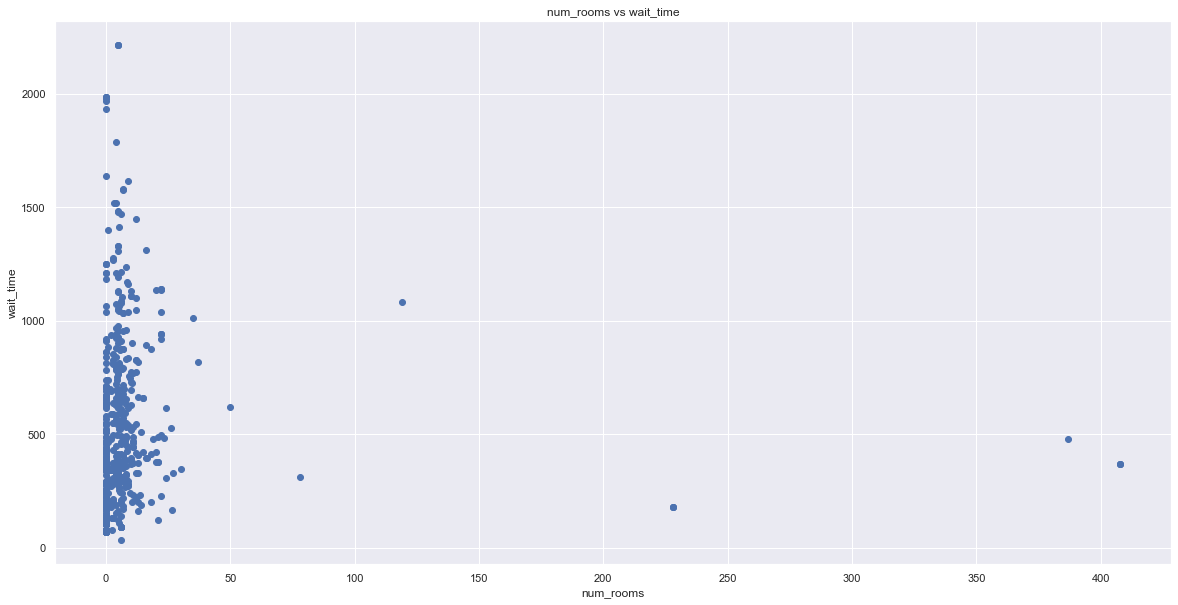

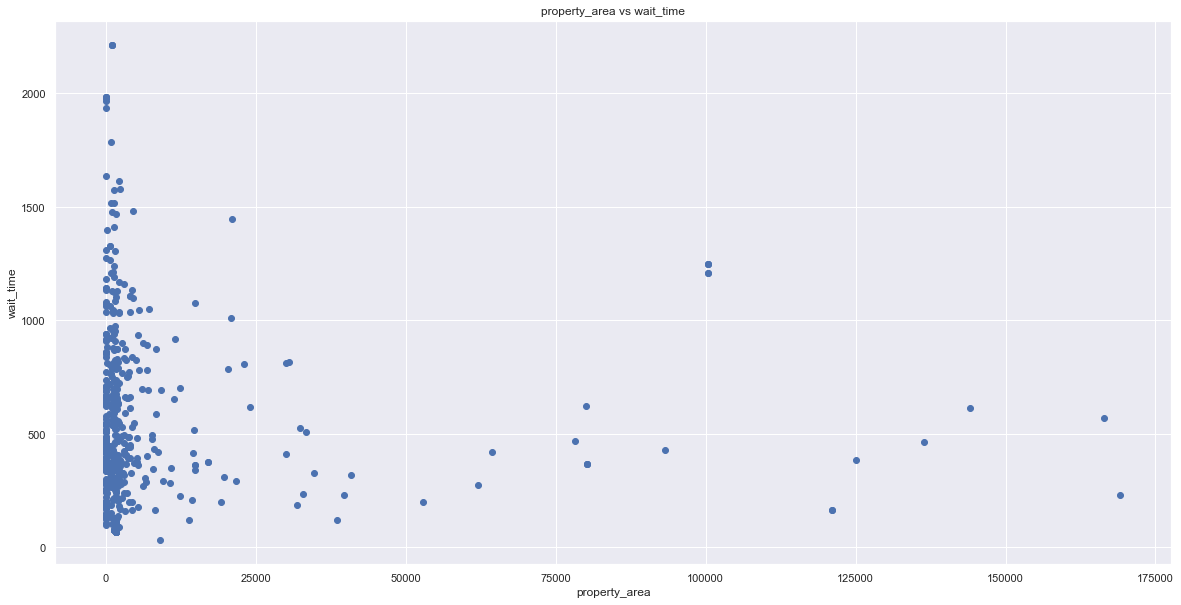

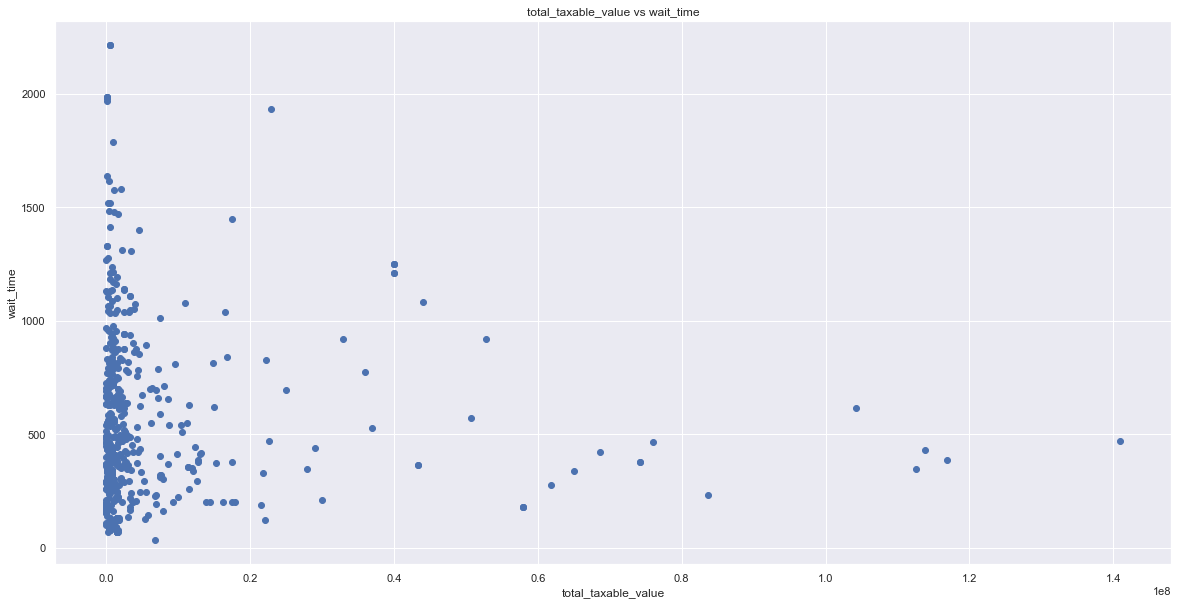

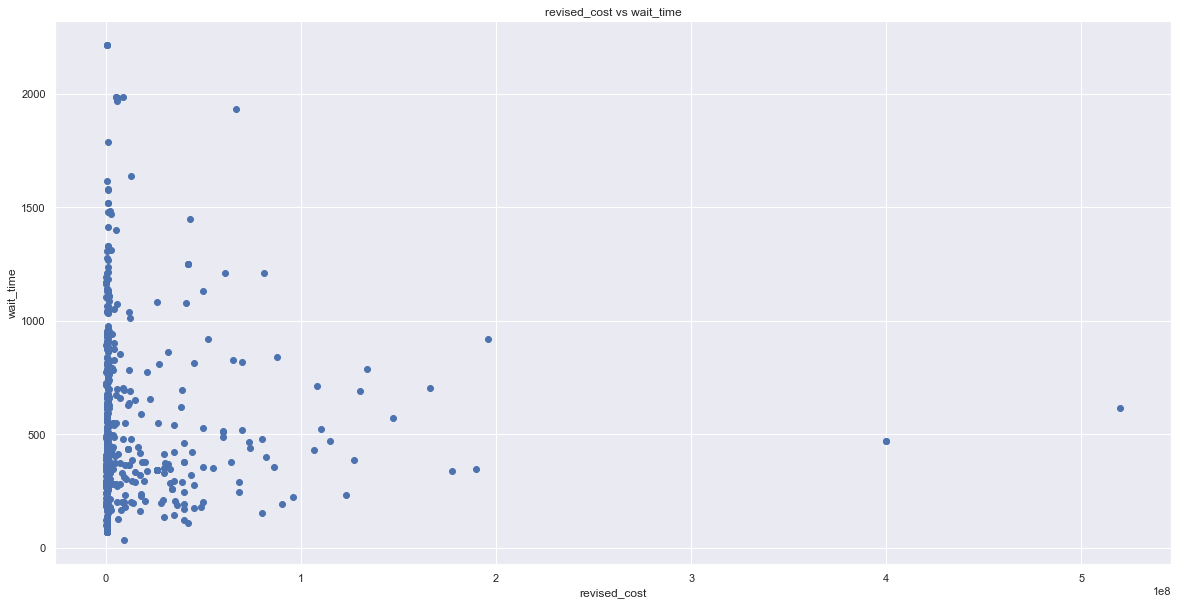

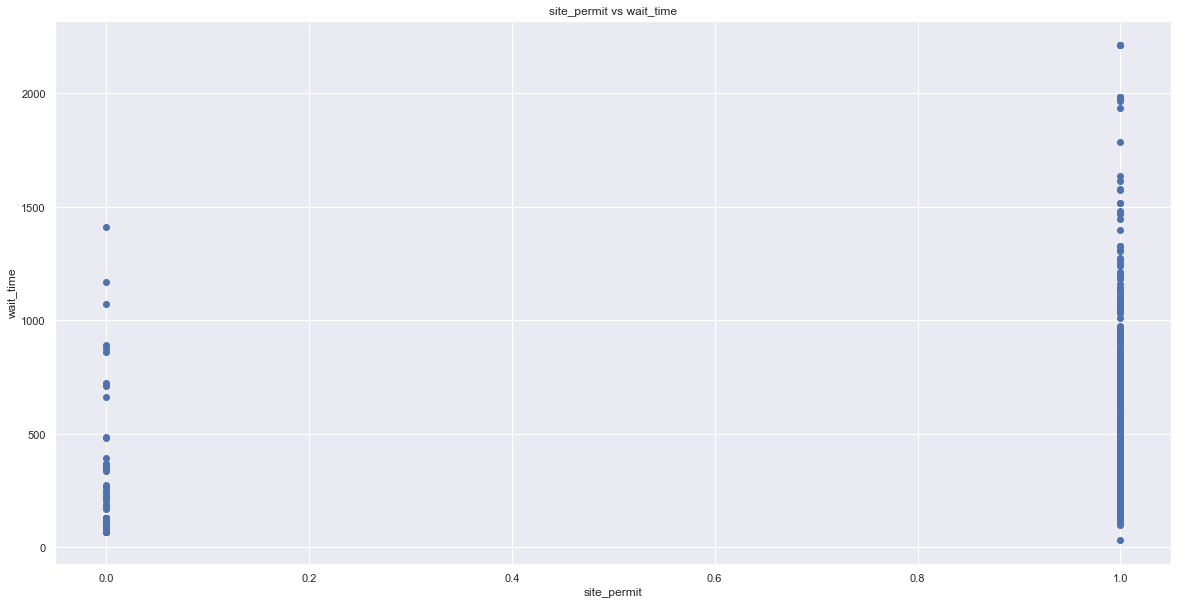

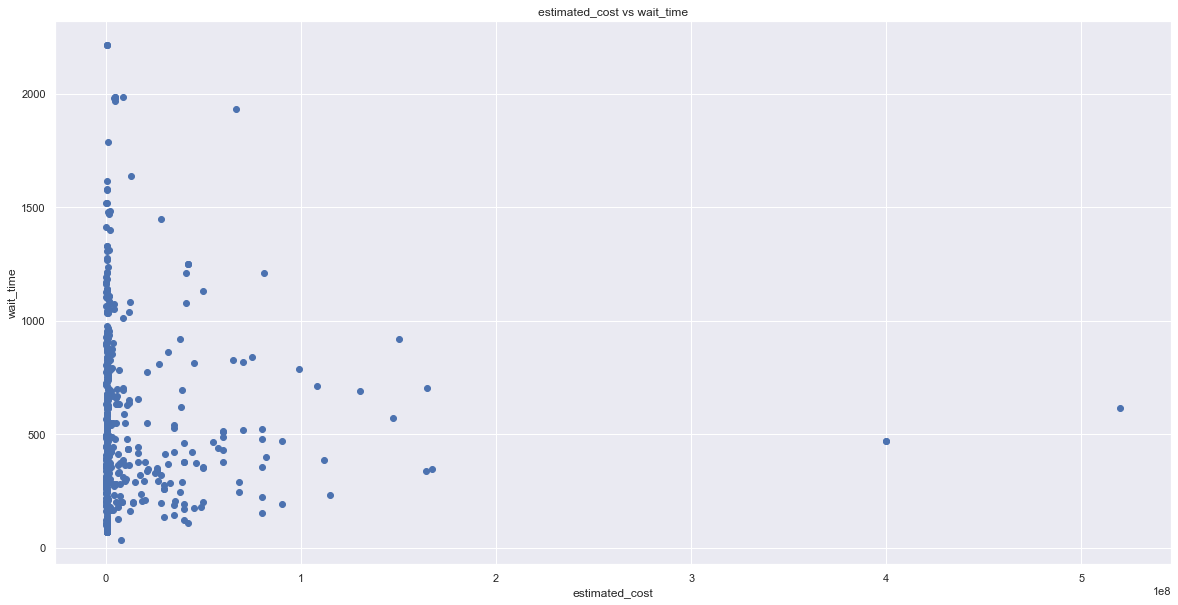

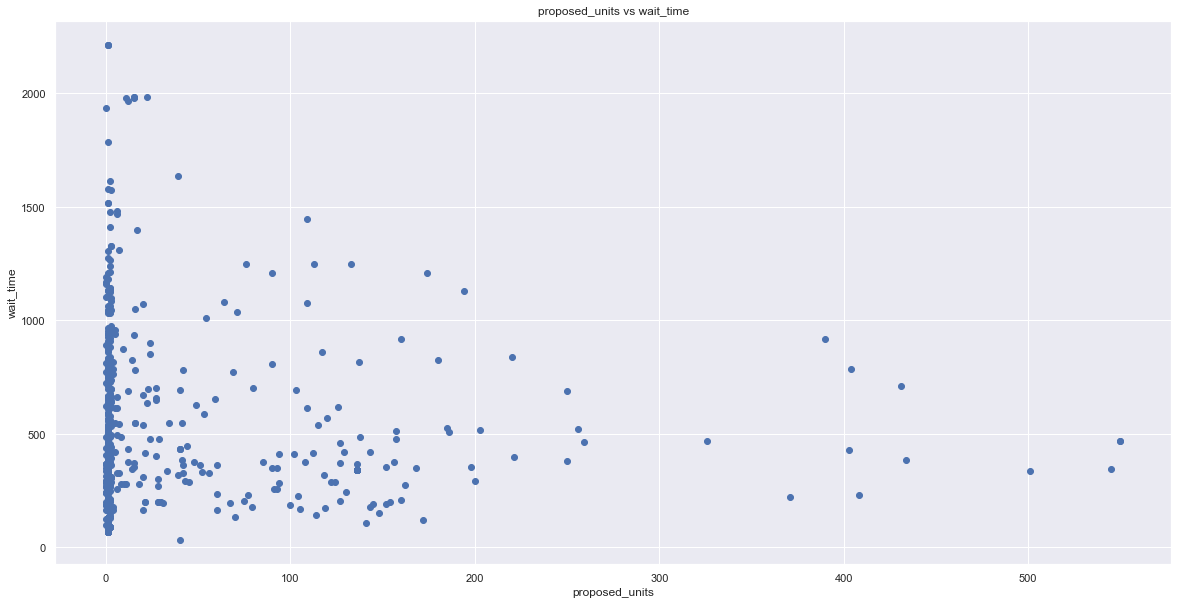

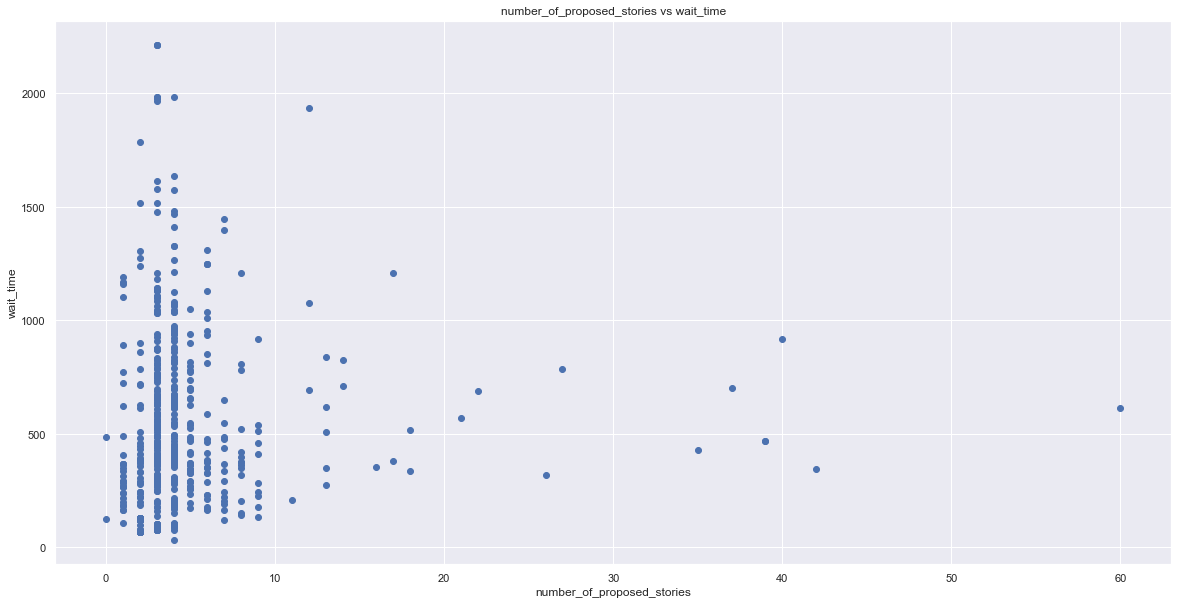

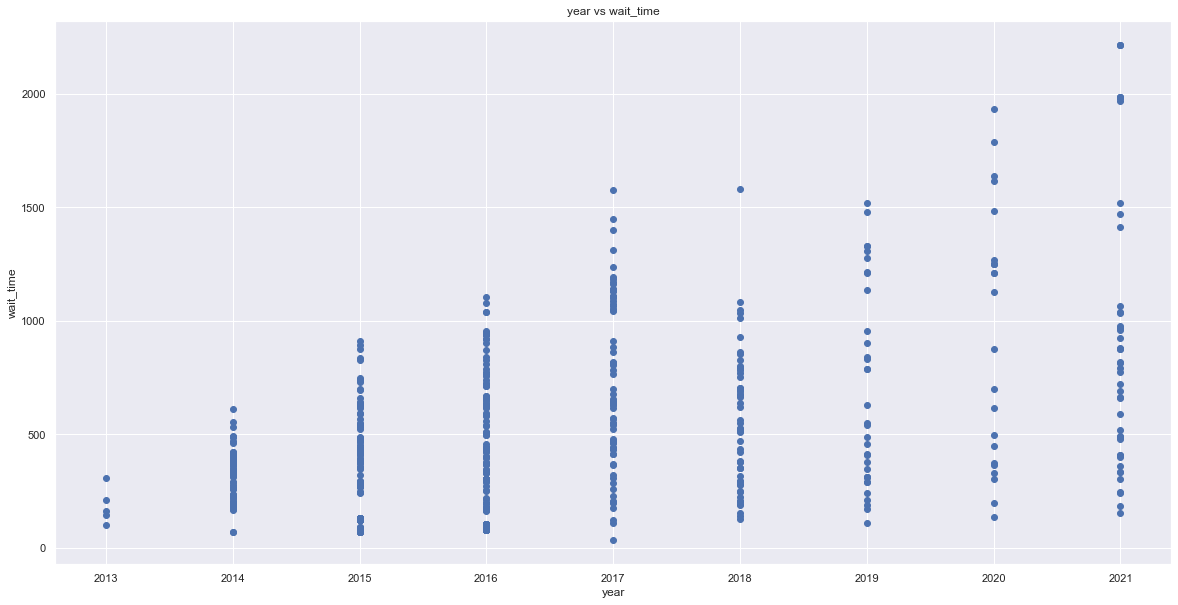

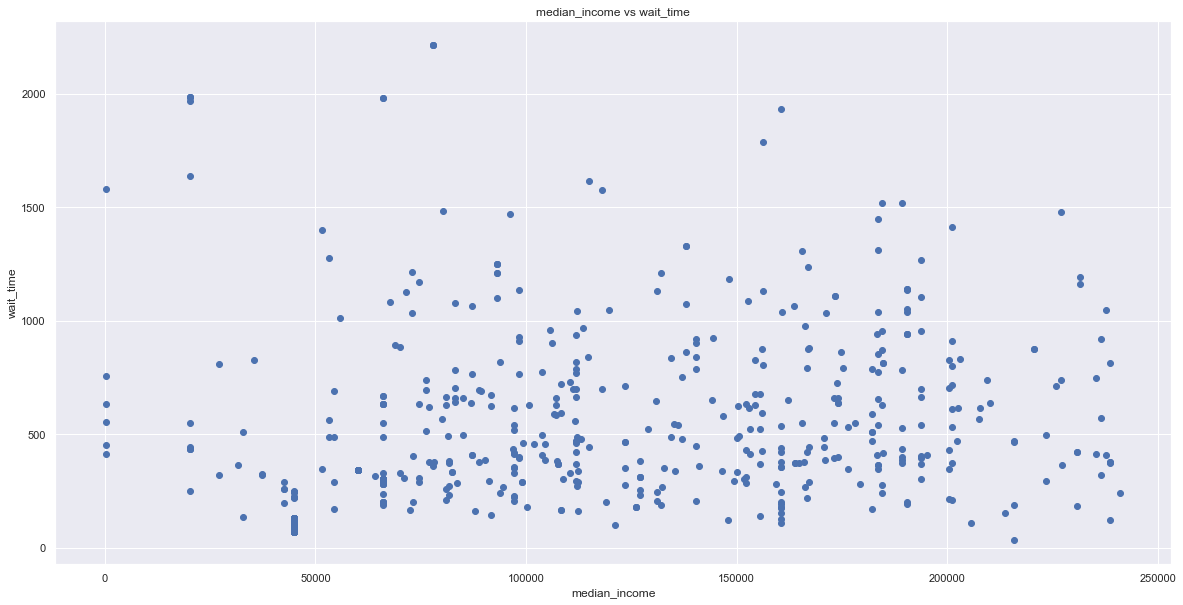

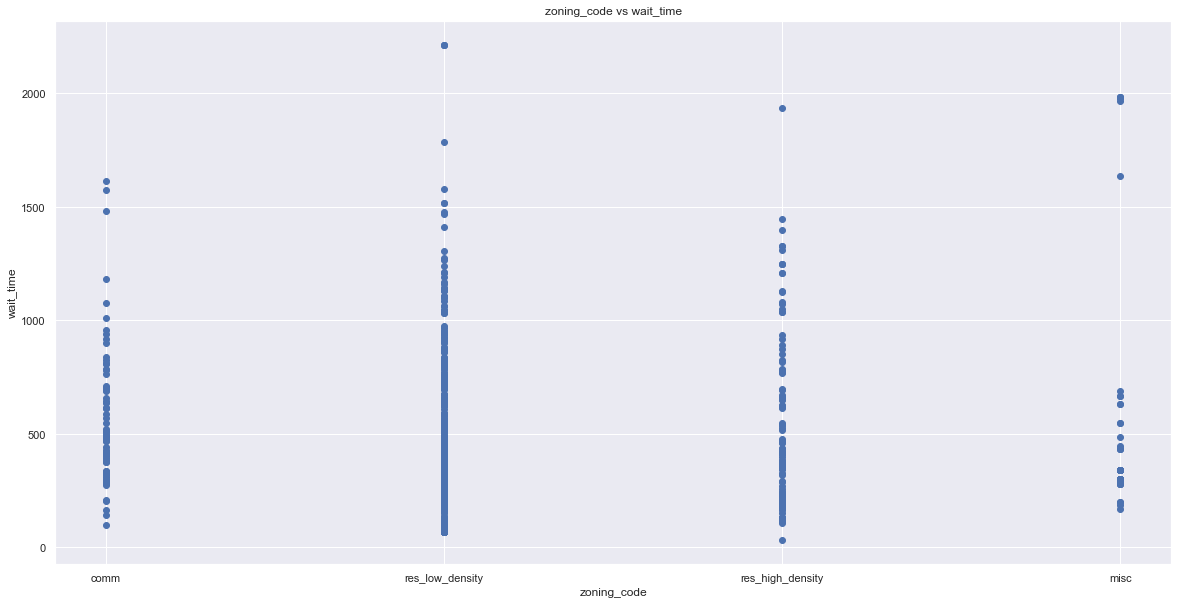

In [87]:
regressors = list(Regression_Table.columns)[1:]

for reg in regressors:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(Regression_Table[reg],Regression_Table['wait_time'])
    ax.set_xlabel(reg)
    ax.set_ylabel('wait_time')
    ax.set_title("{} vs {}".format(reg,'wait_time'))
    plt.show()

<AxesSubplot:xlabel='zoning_code', ylabel='wait_time'>

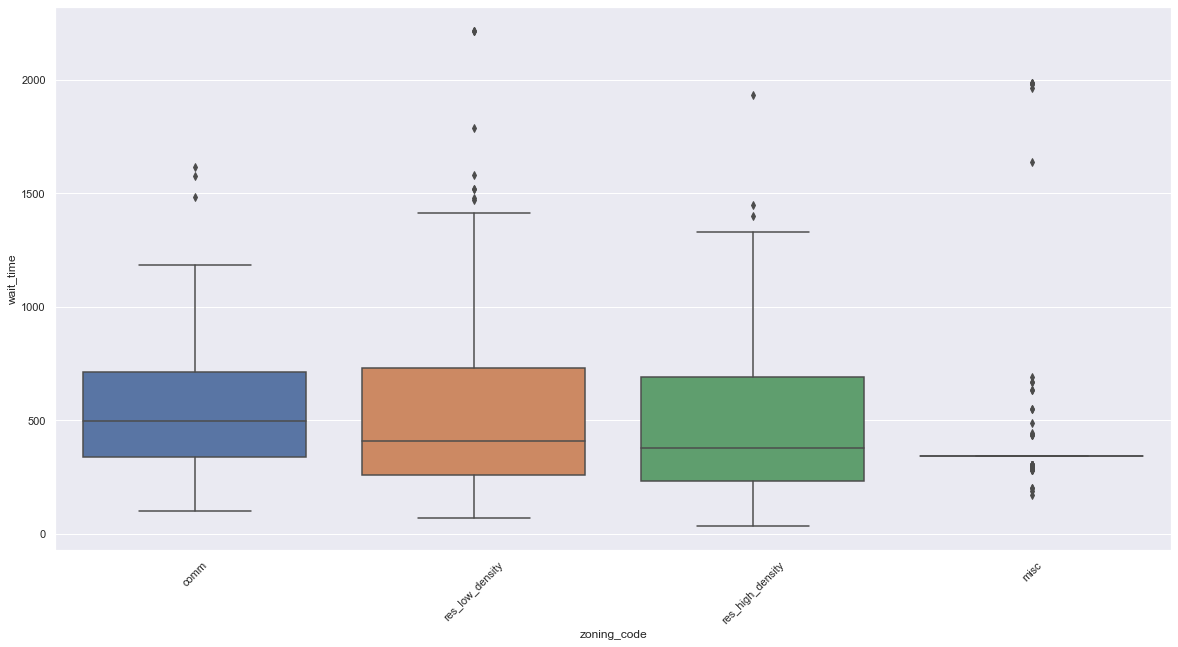

In [88]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.xticks(rotation=45)
sns.boxplot(y='wait_time',x='zoning_code',data=Regression_Table)

In [24]:
#pd.get_dummies(Regression_Table['zoning_code'])
Regression_Table_wDummies = pd.get_dummies(data=Regression_Table, columns = ['zoning_code']); Regression_Table_wDummies.head()
#(Regression_Table_wDummies ==0).sum()/len(Regression_Table_wDummies)

,wait_time,num_rooms,property_area,total_taxable_value,revised_cost,site_permit,estimated_cost,proposed_units,number_of_proposed_stories,year,median_income,zoning_code_comm,zoning_code_misc,zoning_code_res_high_density,zoning_code_res_low_density
0,422.0,20.0,8724.0,3807388.0,2500000.0,True,2500000.0,5.0,4.0,2016,166630.0,1,0,0,0
2,219.0,7.0,2628.0,3335619.0,100000.0,True,60000.0,1.0,1.0,2014,166630.0,0,0,0,1
3,792.0,7.0,2040.0,227016.0,3300000.0,True,3300000.0,1.0,3.0,2018,166630.0,0,0,0,1
1,312.0,78.0,19656.0,7472485.0,9300000.0,True,8500000.0,20.0,4.0,2014,152167.0,1,0,0,0
4,285.0,3.0,990.0,109634.0,60000.0,True,60000.0,0.0,1.0,2015,152167.0,0,0,0,1


In [25]:
outlierIndex = (Regression_Table_wDummies['num_rooms'] < 100) & \
(Regression_Table_wDummies['property_area'] < 50000) & \
(Regression_Table_wDummies['total_taxable_value'] < 0.6e8) & \
(Regression_Table_wDummies['revised_cost'] < 2e8) & \
(Regression_Table_wDummies['estimated_cost'] < 2e8) & \
(Regression_Table_wDummies['proposed_units'] < 300) & \
(Regression_Table_wDummies['number_of_proposed_stories'] < 30)

Regression_Table_wDummies_no_outliers = Regression_Table_wDummies.loc[outlierIndex]
(Regression_Table_wDummies.shape, Regression_Table_wDummies_no_outliers.shape)

((693, 15), (656, 15))

In [97]:
Regression_Table_wDummies.corr().sort_values(by='wait_time', ascending =False)

,wait_time,num_rooms,property_area,total_taxable_value,revised_cost,site_permit,estimated_cost,proposed_units,number_of_proposed_stories,year,median_income,zoning_code_misc,zoning_code_res_high_density,zoning_code_res_low_density
wait_time,1.000000,-0.004827,0.038674,0.024734,-0.025040,0.273760,-0.031940,-0.140666,0.037689,0.524887,0.255631,-0.156999,0.036037,0.065146
year,0.524887,0.041012,0.042236,-0.030125,0.006344,0.052932,0.001133,-0.225549,0.050603,1.000000,0.304188,-0.402905,0.142828,0.179913
site_permit,0.273760,-0.096186,0.009783,0.080745,0.158859,1.000000,0.156831,0.241676,0.180844,0.052932,0.194987,0.236778,-0.015083,-0.269338
median_income,0.255631,0.068205,0.140918,0.269686,0.074499,0.194987,0.056317,-0.101500,0.126899,0.304188,1.000000,-0.489980,0.196926,0.223421
zoning_code_res_low_density,0.065146,-0.008475,-0.148019,-0.187587,-0.358287,-0.269338,-0.351296,-0.562140,-0.338958,0.179913,0.223421,-0.556562,-0.417071,1.000000
property_area,0.038674,0.212893,1.000000,0.602026,0.356550,0.009783,0.336815,0.234192,0.276528,0.042236,0.140918,-0.150379,0.266178,-0.148019
number_of_proposed_stories,0.037689,-0.039883,0.276528,0.478951,0.872696,0.180844,0.849823,0.628321,1.000000,0.050603,0.126899,0.005178,0.187437,-0.338958
zoning_code_res_high_density,0.036037,0.160182,0.266178,0.337406,0.160910,-0.015083,0.141939,0.169102,0.187437,0.142828,0.196926,-0.285119,1.000000,-0.417071
total_taxable_value,0.024734,0.119606,0.602026,1.000000,0.494055,0.080745,0.449177,0.428986,0.478951,-0.030125,0.269686,-0.178526,0.337406,-0.187587
num_rooms,-0.004827,1.000000,0.212893,0.119606,-0.010365,-0.096186,-0.010769,-0.062615,-0.039883,0.041012,0.068205,-0.126461,0.160182,-0.008475


In [98]:
Regression_Table_wDummies_no_outliers.corr().sort_values(by='wait_time',ascending =False)

,wait_time,num_rooms,property_area,total_taxable_value,revised_cost,site_permit,estimated_cost,proposed_units,number_of_proposed_stories,year,median_income,zoning_code_misc,zoning_code_res_high_density,zoning_code_res_low_density
wait_time,1.000000,0.187918,-0.017489,0.038149,-0.118435,0.276968,-0.128822,-0.206730,0.002166,0.512766,0.276943,-0.157846,0.008414,0.089102
year,0.512766,0.188887,0.040129,0.009319,-0.081970,0.046838,-0.095815,-0.330140,0.018901,1.000000,0.338037,-0.412830,0.134801,0.207593
site_permit,0.276968,0.093784,0.053288,0.098857,0.256530,1.000000,0.254205,0.277955,0.292466,0.046838,0.194664,0.247276,-0.013167,-0.285251
median_income,0.276943,0.290282,0.099932,0.254047,-0.111924,0.194664,-0.133663,-0.264525,-0.017044,0.338037,1.000000,-0.489359,0.176696,0.269604
num_rooms,0.187918,1.000000,0.436405,0.206834,-0.147498,0.093784,-0.169612,-0.221396,-0.007804,0.188887,0.290282,-0.358663,0.090116,0.147843
zoning_code_res_low_density,0.089102,0.147843,-0.133657,-0.213705,-0.560151,-0.285251,-0.558027,-0.639048,-0.497318,0.207593,0.269604,-0.599262,-0.396542,1.000000
total_taxable_value,0.038149,0.206834,0.453656,1.000000,0.281528,0.098857,0.237831,0.143659,0.355200,0.009319,0.254047,-0.223309,0.431502,-0.213705
zoning_code_res_high_density,0.008414,0.090116,0.210368,0.431502,0.242478,-0.013167,0.222312,0.108691,0.352482,0.134801,0.176696,-0.271802,1.000000,-0.396542
number_of_proposed_stories,0.002166,-0.007804,0.225719,0.355200,0.746011,0.292466,0.722284,0.628736,1.000000,0.018901,-0.017044,0.150668,0.352482,-0.497318
property_area,-0.017489,0.436405,1.000000,0.453656,0.164543,0.053288,0.140740,0.108701,0.225719,0.040129,0.099932,-0.184641,0.210368,-0.133657


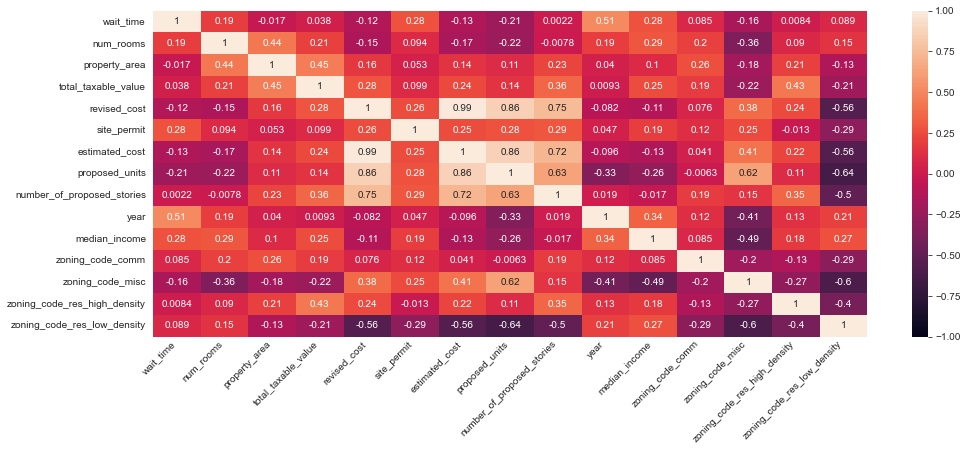

In [55]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(Regression_Table_wDummies_no_outliers.corr(), vmin = -1, vmax = 1, annot = True)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='x', pad=-1)
plt.savefig('corr_table.png', bbox_inches = 'tight', dpi = 300)

In [28]:
Regression_Table_no_outliers_no_dummy.describe()

,wait_time,num_rooms,property_area,total_taxable_value,revised_cost,estimated_cost,proposed_units,number_of_proposed_stories,year,median_income
count,656.000000,656.000000,656.000000,6.560000e+02,6.560000e+02,6.560000e+02,656.000000,656.000000,656.000000,656.000000
mean,491.734756,4.296029,2503.840346,2.419846e+06,1.186705e+07,1.130010e+07,46.400915,4.153963,2016.102134,102187.466463
std,361.947282,6.430573,5127.610274,5.124920e+06,1.707887e+07,1.650540e+07,62.512772,2.331153,2.102763,56625.117762
min,35.000000,0.000000,0.000000,0.000000e+00,1.000000e+03,1.000000e+00,0.000000,0.000000,2013.000000,250.000000
25%,303.000000,0.000000,817.000000,4.292945e+05,5.250000e+05,4.000000e+05,1.000000,3.000000,2014.000000,60104.000000
50%,340.000000,3.000000,1300.000000,7.485275e+05,1.325000e+06,1.000000e+06,2.000000,4.000000,2016.000000,77473.000000
75%,631.000000,6.000000,1741.821429,1.769018e+06,2.600000e+07,2.600000e+07,136.000000,5.000000,2017.000000,152928.500000
max,2212.000000,78.000000,40796.800000,4.334277e+07,1.302400e+08,1.302400e+08,256.000000,26.000000,2021.000000,241167.000000


In [93]:
#census_merge.to_file('C:/Users/Rohan/Documents/NYU/PUI/SFPermitTimes/Data/census_merged.geojson', driver = 'GeoJSON')

In [305]:
X = Regression_Table_wDummies.iloc[:,1:].values
y = Regression_Table_wDummies['wait_time'].values
feature_names = np.array(Regression_Table_wDummies.iloc[:,1:].columns)

In [306]:
lasso_estimator = LassoCV().fit(X,y)
lasso_selector = SequentialFeatureSelector(lasso_estimator, n_features_to_select=5, direction='forward').fit(X, y)
wDummies_lasso_features = lasso_selector.get_feature_names_out(feature_names)

lasso_model_wDummies = smf.ols(formula = 'wait_time ~ '+ '+'.join(wDummies_lasso_features), data = Regression_Table_wDummies).fit()    
print(lasso_model_wDummies.summary())

C:\Users\Rohan\anaconda3\envs\geo_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+04, tolerance: 9.021e+03
  model = cd_fast.enet_coordinate_descent(


                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     70.19
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.62e-59
Time:                        16:33:37   Log-Likelihood:                -4920.9
No. Observations:                 693   AIC:                             9854.
Df Residuals:                     687   BIC:                             9881.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

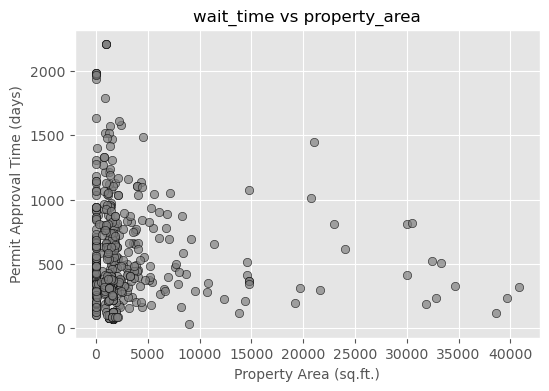

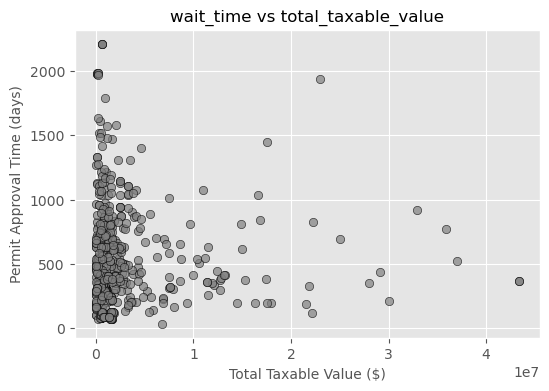

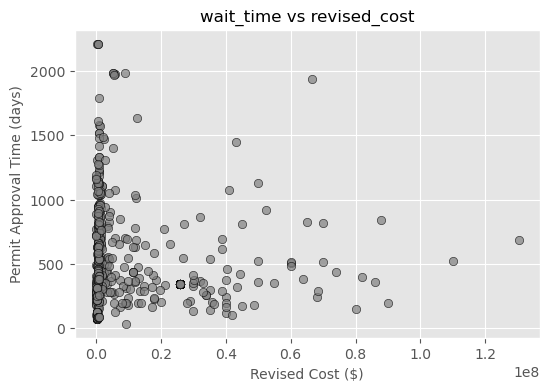

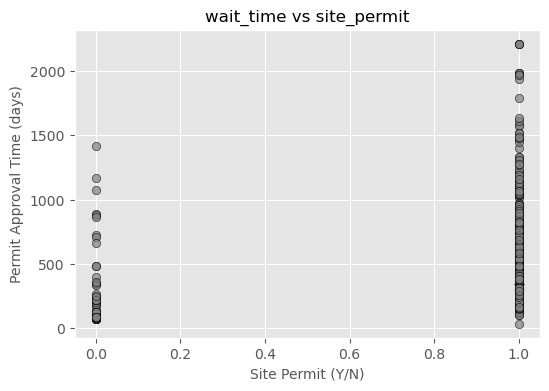

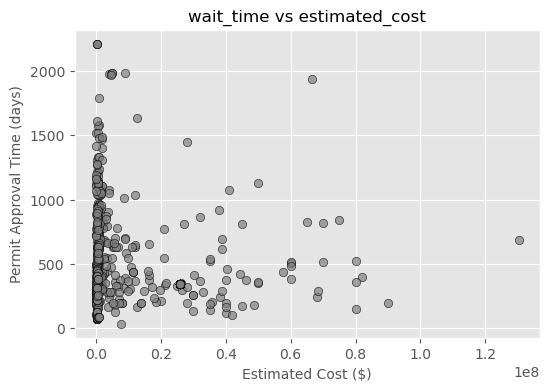

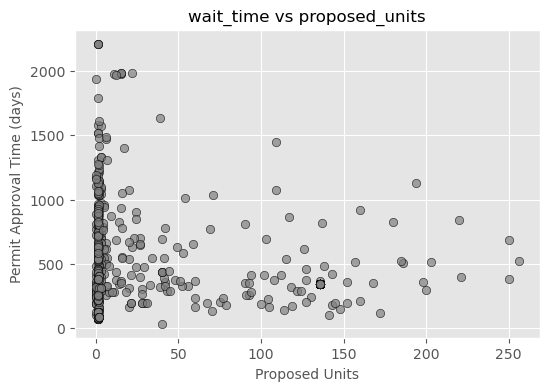

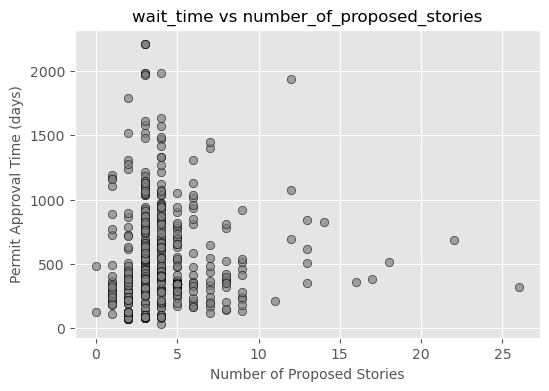

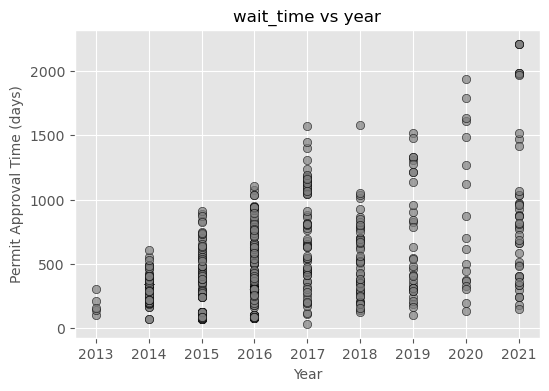

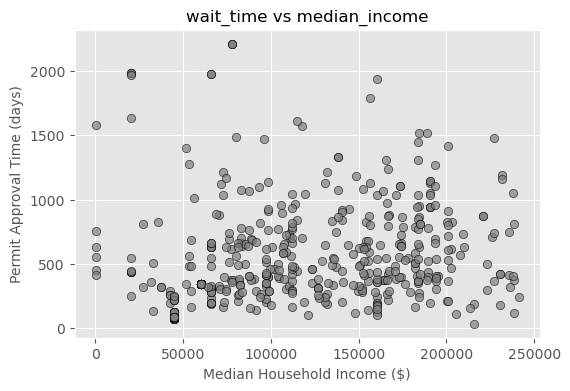

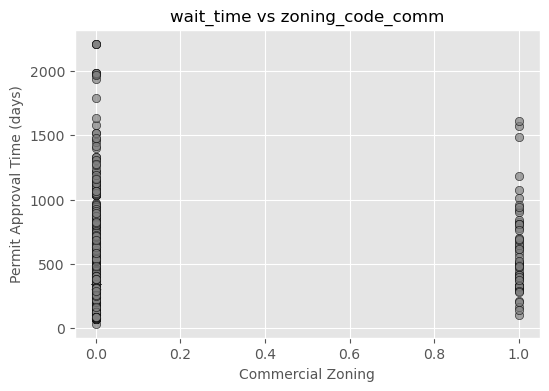

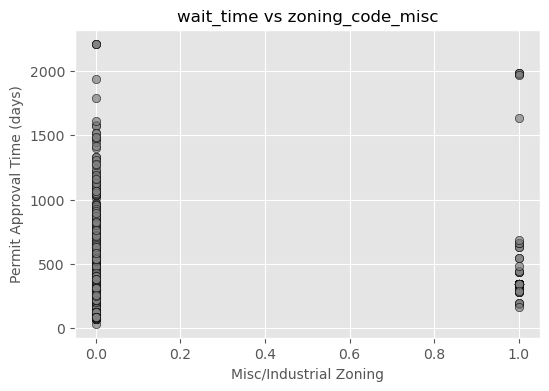

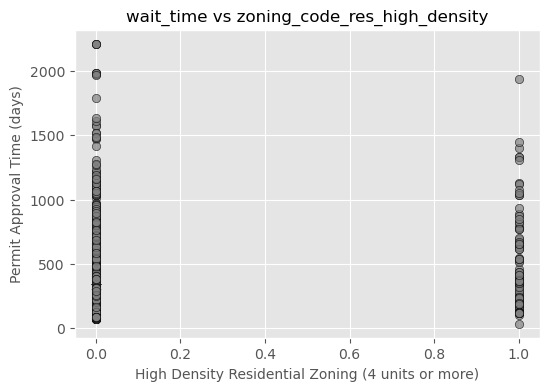

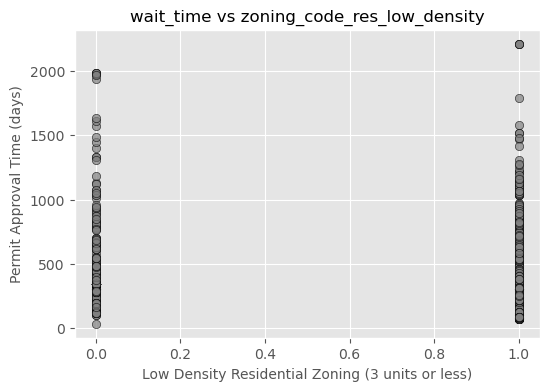

In [374]:
regressors = list(Regression_Table_wDummies_no_outliers.columns)[1:]
regressor_dict = {'property_area': 'Property Area (sq.ft.)','total_taxable_value':'Total Taxable Value ($)',
                 'revised_cost':'Revised Cost ($)', 'estimated_cost':'Estimated Cost ($)',
                 'site_permit':'Site Permit (Y/N)', 'proposed_units':'Proposed Units', 
                 'number_of_proposed_stories':'Number of Proposed Stories', 'year':'Year',
                 'median_income':'Median Household Income ($)', 'zoning_code_comm': 'Commercial Zoning',
                 'zoning_code_misc': 'Misc/Industrial Zoning', 
                 'zoning_code_res_low_density': 'Low Density Residential Zoning (3 units or less)',
                 'zoning_code_res_high_density': 'High Density Residential Zoning (4 units or more)'}

plt.style.use('ggplot')

for reg in regressors[1:]:
    fig, ax = plt.subplots(figsize = (6,4))
    ax.scatter(Regression_Table_wDummies_no_outliers[reg],Regression_Table_wDummies_no_outliers['wait_time'],
              edgecolor = 'k', facecolor = 'grey', alpha = 0.7)
    ax.set_xlabel(reg.replace(reg,regressor_dict[reg]), fontsize = 10)
    ax.set_ylabel('Permit Approval Time (days)', fontsize = 10)
    ax.set_title("wait_time vs {}".format(reg), fontsize = 12)
    plt.savefig('{}.png'.format(reg), bbox_inches = 'tight', dpi = 300)

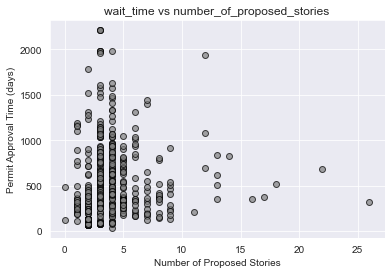

In [30]:
fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(data = Regression_Table_no_outliers_no_dummy, x = 'number_of_proposed_stories', y = 'wait_time', 
           edgecolor = 'k', facecolor = 'grey', alpha = 0.7)
ax.set_xlabel('Number of Proposed Stories', fontsize = 10)
ax.set_ylabel('Permit Approval Time (days)', fontsize = 10)
ax.set_title("wait_time vs number_of_proposed_stories", fontsize = 12)
   # plt.savefig('{}.png'.format(reg), bbox_inches = 'tight', dpi = 300)
plt.show()

In [31]:
print(smf.ols(formula = 'wait_time~number_of_proposed_stories', data = Regression_Table_no_outliers_no_dummy).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.003067
Date:                Thu, 09 Dec 2021   Prob (F-statistic):              0.956
Time:                        01:52:09   Log-Likelihood:                -4795.1
No. Observations:                 656   AIC:                             9594.
Df Residuals:                     654   BIC:                             9603.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
base_model = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories', data = Regression_Table_wDummies_no_outliers).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     109.1
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.88e-57
Time:                        17:28:34   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9331.
Df Residuals:                     652   BIC:                             9349.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [36]:
w_low_density = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories+zoning_code_res_low_density', 
                        data = Regression_Table_wDummies_no_outliers).fit()
print(w_low_density.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     81.96
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.43e-56
Time:                        17:28:54   Log-Likelihood:                -4661.4
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9355.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [37]:
w_high_density = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories+zoning_code_res_high_density', 
                        data = Regression_Table_wDummies_no_outliers).fit()
print(w_high_density.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     81.99
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.35e-56
Time:                        17:29:34   Log-Likelihood:                -4661.3
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9355.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [38]:
w_comm = smf.ols(formula = 'wait_time~year+site_permit+number_of_proposed_stories+zoning_code_comm', 
                        data = Regression_Table_wDummies_no_outliers).fit()
print(w_comm.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     81.74
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           3.24e-56
Time:                        17:31:56   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [313]:
X_no_outliers = Regression_Table_wDummies_no_outliers.iloc[:,1:].values
y_no_outliers = Regression_Table_wDummies_no_outliers['wait_time'].values

In [315]:
lasso_estimator_no_outliers = LassoCV().fit(X_no_outliers,y_no_outliers)
lasso_selector_no_outliers = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=4, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
lasso_features_no_outliers = lasso_selector_no_outliers.get_feature_names_out(feature_names)

lasso_model_no_outliers = smf.ols(formula = 'wait_time ~ '+ '+'.join(lasso_features_no_outliers), data = Regression_Table_wDummies_no_outliers).fit()    
print(lasso_model_no_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     81.74
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           3.24e-56
Time:                        16:40:55   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9333.
Df Residuals:                     651   BIC:                             9356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [185]:
lasso_selector_no_outliers_bck = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=5, 
                                                       direction='backward').fit(X_no_outliers, y_no_outliers)
lasso_selector_no_outliers.get_feature_names_out(feature_names)

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_MUR', 'zoning_code_RH-1(D)'], dtype=object)

In [186]:
lasso_model_no_outliers_bck = smf.ols(formula = 'wait_time ~ site_permit+year+number_of_proposed_stories+Q("zoning_code_MUR")+Q("zoning_code_RH-1(D)")', 
                                  data = Regression_Table_wDummies_no_outliers).fit()
print(lasso_model_no_outliers_bck.

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     68.07
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           3.31e-57
Time:                        18:09:16   Log-Likelihood:                -4657.0
No. Observations:                 656   AIC:                             9326.
Df Residuals:                     650   BIC:                             9353.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [317]:
#test for best number of features
lasso_estimator_no_outliers = LassoCV().fit(X_no_outliers,y_no_outliers)
sel_features = []
for num in np.arange(1,6):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names))

sel_features


[array(['year'], dtype=object),
 array(['site_permit', 'year'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year',
        'zoning_code_comm'], dtype=object),
 array(['num_rooms', 'site_permit', 'number_of_proposed_stories', 'year',
        'zoning_code_comm'], dtype=object)]

In [203]:
r2 = []
for num in np.arange(0,4):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_wDummies_no_outliers).fit()
    r2.append(lm.rsquared)
    
r2

[0.26292884876082334,
 0.3270539489511274,
 0.3314908634152024,
 0.336855352658208]

In [204]:
lasso_selector_no_outliers_10 = SequentialFeatureSelector(lasso_estimator_no_outliers, 
                                                       n_features_to_select=10, 
                                                       direction='forward').fit(X_no_outliers, y_no_outliers)
lasso_selector_no_outliers_10.get_feature_names_out(feature_names)

array(['site_permit', 'number_of_proposed_stories', 'year',
       'zoning_code_C-3-G', 'zoning_code_HP-RA|M-1|RM-1',
       'zoning_code_HP-RA|RM-1', 'zoning_code_MUR', 'zoning_code_P|RM-1',
       'zoning_code_RH-1(D)', 'zoning_code_RM-4'], dtype=object)

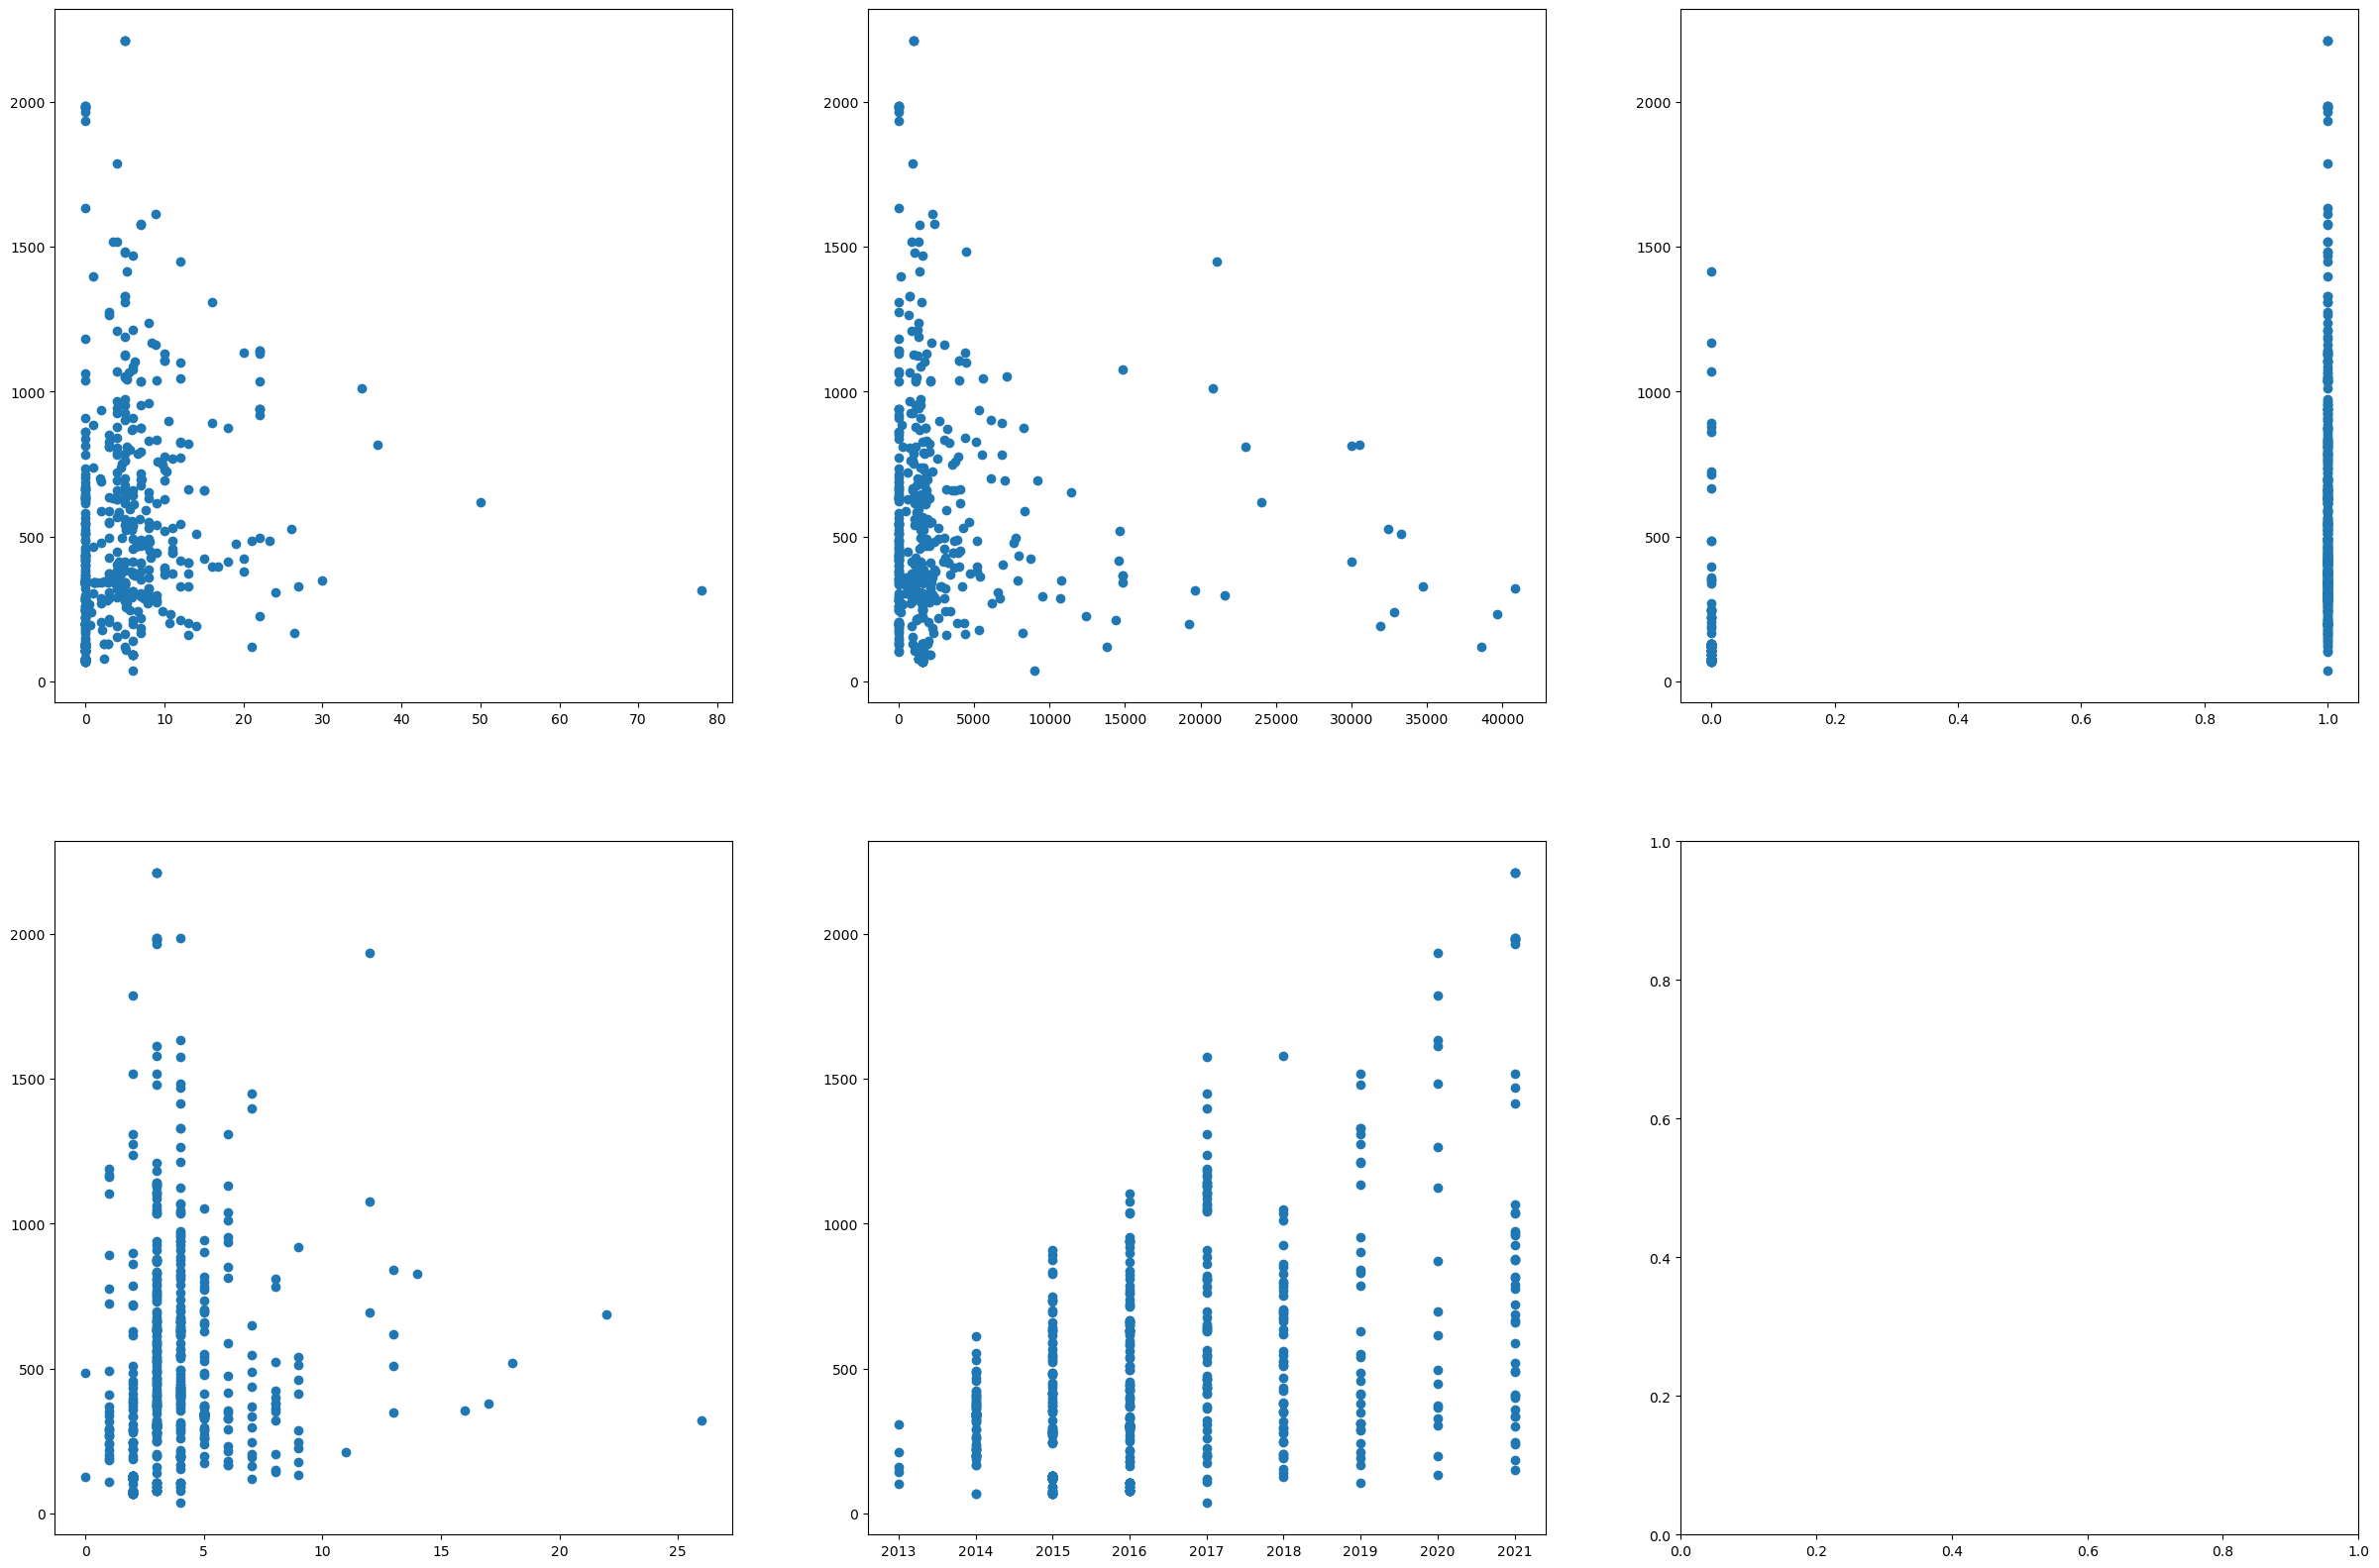

In [316]:
fig, ax = plt.subplots(2, 3, figsize = (30,20))
ax = ax.ravel()
for feature, i in zip(sel_features[4], range(6)):
    ax[i].scatter(data = Regression_Table_wDummies_no_outliers, x = feature, y = 'wait_time')

In [26]:
Regression_Table_no_outliers_no_dummy = Regression_Table.loc[outlierIndex].drop(columns = 'zoning_code').reset_index(drop = True)
Regression_Table_no_outliers_no_dummy.shape

(656, 11)

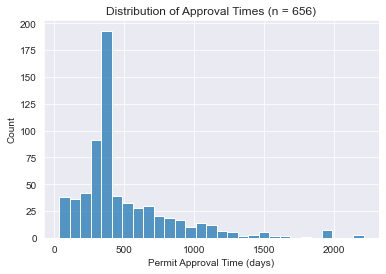

In [27]:
sns.set_style('darkgrid')
sns.histplot(data = Regression_Table_no_outliers_no_dummy, x = 'wait_time')
plt.xlabel('Permit Approval Time (days)')
plt.title('Distribution of Approval Times (n = 656)')
plt.savefig('wait_time_dist', bbox_inches = 'tight',dpi = 300)

In [15]:
Regression_Table_no_outliers.shape

NameError: name 'Regression_Table_no_outliers' is not defined

In [278]:
lasso_estimator_no_dummy_no_outliers = LassoCV().fit(X_no_dummy_no_outlier,y_no_dummy_no_outlier)

sel_features = []

for num in np.arange(1,10):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_dummy_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_dummy_no_outlier, 
                                                                                y_no_dummy_no_outlier)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names_2))

sel_features

[array(['year'], dtype=object),
 array(['site_permit', 'year'], dtype=object),
 array(['site_permit', 'number_of_proposed_stories', 'year'], dtype=object),
 array(['num_rooms', 'site_permit', 'number_of_proposed_stories', 'year'],
       dtype=object),
 array(['num_rooms', 'property_area', 'site_permit',
        'number_of_proposed_stories', 'year'], dtype=object),
 array(['num_rooms', 'property_area', 'site_permit', 'proposed_units',
        'number_of_proposed_stories', 'year'], dtype=object)]

In [280]:
r2 = []
loglike = []

for num in np.arange(len(sel_features)):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_no_outliers).fit()
    r2.append(lm.rsquared)
    loglike.append(lm.llf)

,R2,Log Likelyhood
0,0.262929,-4695.083120
1,0.327054,-4665.228801
2,0.334308,-4661.674044
3,0.338908,-4659.399366
4,0.344094,-4656.816610
5,0.349108,-4654.299599


In [281]:
pd.DataFrame({'Features':sel_features,'R2':r2, 'Log Likelyhood':loglike})

,Features,R2,Log Likelyhood
0,[year],0.262929,-4695.083120
1,"[site_permit, year]",0.327054,-4665.228801
2,"[site_permit, number_of_proposed_stories, year]",0.334308,-4661.674044
3,"[num_rooms, site_permit, number_of_proposed_st...",0.338908,-4659.399366
4,"[num_rooms, property_area, site_permit, number...",0.344094,-4656.816610
5,"[num_rooms, property_area, site_permit, propos...",0.349108,-4654.299599


In [353]:
lasso_estimator_no_dummy_no_outliers = LassoCV().fit(X_no_dummy_no_outlier,y_no_dummy_no_outlier)

sel_features = []
r2 = []
loglike = []

for num in np.arange(1,8):
    lasso_selector = SequentialFeatureSelector(lasso_estimator_no_dummy_no_outliers, 
                                                       n_features_to_select=num, 
                                                       direction='forward').fit(X_no_dummy_no_outlier, 
                                                                                y_no_dummy_no_outlier)
    sel_features.append(lasso_selector.get_feature_names_out(feature_names_2))

for num in np.arange(len(sel_features)):
    lm = smf.ols(formula = 'wait_time ~ '+ '+'.join(sel_features[num]), data = Regression_Table_no_outliers_no_dummy).fit()
    r2.append(lm.rsquared)
    loglike.append(lm.llf)    
    print(lm.summary())

r2_table = pd.DataFrame({'Features':sel_features,'R2':r2, 'Log Likelyhood':loglike}); r2_table

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     233.3
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.87e-45
Time:                        17:20:45   Log-Likelihood:                -4695.1
No. Observations:                 656   AIC:                             9394.
Df Residuals:                     654   BIC:                             9403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.775e+05   1.17e+04    -15.232      0.0

,Features,R2,Log Likelyhood
0,[year],0.262929,-4695.083120
1,"[site_permit, year]",0.327054,-4665.228801
2,"[site_permit, number_of_proposed_stories, year]",0.334308,-4661.674044
3,"[property_area, site_permit, number_of_propose...",0.335416,-4661.127719
4,"[property_area, site_permit, proposed_units, n...",0.343933,-4656.896618
5,"[property_area, site_permit, proposed_units, n...",0.345369,-4656.178051
6,"[property_area, total_taxable_value, site_perm...",0.346933,-4655.393791


In [366]:
final_model = smf.ols(formula = 'wait_time ~ '+ '+'.join(r2_table.iloc[2]['Features']), data = Regression_Table_no_outliers_no_dummy).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     109.1
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.88e-57
Time:                        18:06:08   Log-Likelihood:                -4661.7
No. Observations:                 656   AIC:                             9331.
Df Residuals:                     652   BIC:                             9349.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [59]:
len(census_merge.loc[census_merge['site_permit'] == 0])

89

In [58]:
 census_merge.columns

Index(['project_id_drop', 'from_address_num', 'date_map_alt', 'odd_even',
       'zoning_code', 'zoning_district', 'pw_recorded_map', 'mapblklot',
       'date_map_add', 'to_address_num', 'street_name_x', 'project_id_alt',
       'date_map_drop', 'street_type', 'project_id_add', 'date_rec_drop',
       'block_num', 'blklot', 'in_asr_secured_roll', 'date_rec_add', 'lot_num',
       'active', 'geometry_x', 'Parcel Number_x', 'Number of Rooms',
       'Property Area', 'Total Taxable Value', 'record_id', 'issued_date',
       'zipcode', 'neighborhoods_analysis_boundaries', 'proposed_use',
       'description', 'revised_cost', 'site_permit', 'plansets',
       'permit_creation_date', 'status_date',
       'first_construction_document_date', 'filed_date', 'street_name_y',
       'block', 'estimated_cost', 'permit_expiration_date',
       'permit_type_definition', 'status', 'completed_date', 'permit_number',
       'lot', 'street_suffix', 'proposed_units', 'permit_type',
       'number_of_pro